In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, "./../")
import json
import utils

from FileManager import FileManager
from ExptTrace import ExptTrace

plt.rc("figure", dpi=120, facecolor=(1, 1, 1))
plt.rc("font", family="Times New Roman", size=12)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=12)
plt.rc("mathtext", fontset='cm')
plt.rcParams['figure.dpi'] = 200

In [2]:
import matplotlib.colors as mcolors

def lighten(hex_color, factor=0.3):
    rgb = mcolors.hex2color(hex_color)
    light_rgb = [max(0, min(1, c + factor * (1 - c))) for c in rgb]
    return mcolors.rgb2hex(light_rgb)

In [ ]:
expt_dir = os.path.join(os.getenv("QWEMPATH"), "stepwise-qwem")
fm = FileManager(expt_dir)
results = fm.load("results.pickle")
with open(fm.get_filename("hypers.json")) as f:
    H = json.load(f)
et_loss, et_acc, et_sv = [ExptTrace.deserialize(x) for x in results]

VOCAB_SZ = H["vocab_sz"]
CONTEXT_LEN = H["context_len"]
LR = H["lr"]
EMBEDDIM = H["embeddim"]

data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("min500")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

analysis_fm = FileManager("../analysis")
eigvecs = analysis_fm.load("mstar-eigvecs.npy")
eigvals = analysis_fm.load("mstar-eigvals.npy")

In [4]:
print(f"Computing M*... ", end="")
corpus_stats = data_fm.load("corpus_stats.pickle")
cL = corpus_stats["context_len"]
Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
PiPj = np.outer(unigram, unigram)
Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
min_loss = -1 * (Mstar**2).mean()
print("done.")

lambda_init = H["init_sz"]**2
lambda_max = np.max(eigvals)
min_loss_adj = min_loss * Pij.sum()
lr_eff = (-1/min_loss_adj) * LR * 4 / (VOCAB_SZ**2)
tscale = (1/lambda_max) * np.log(lambda_max/lambda_init)
tchar = tscale / lr_eff

tt = np.array(et_sv.get_axis("nstep")) / tchar
SVs = np.array(et_sv[:])

def theorycurve(t, lstar):
    t = t * tscale
    t[lstar * t > 100] = 100/lstar
    numer = np.exp(lstar * t)
    denom = 1/lambda_init + (numer-1)/lstar
    return np.sqrt(numer / denom)

tt_th = np.logspace(-1, 2, num=1000, base=10)
SV_th = np.empty((len(tt_th), EMBEDDIM))
for j, eigval in enumerate(eigvals[:EMBEDDIM]):
    SV_th[:, j] = theorycurve(tt_th, eigval)


Computing M*... done.


In [ ]:
model_dir = os.path.join(os.getenv("QWEMPATH"), "stepwise-qwem/models")
model_fm = FileManager(model_dir)
W_t = [
    model_fm.load("W_00001000.npy"),
    model_fm.load("W_00100000.npy"),
    model_fm.load("W_00500000.npy"),
]
for i, W in enumerate(W_t):
    V, S, Ut = np.linalg.svd(W, full_matrices=False)
    W_t[i] = V @ np.diag(S)
print([W.shape for W in W_t])

[(10000, 200), (10000, 200), (10000, 200)]


In [6]:
W_final = model_fm.load("W_final.npy")
V, S, Ut = np.linalg.svd(W_final, full_matrices=False)
W_final = V @ np.diag(S)

NORMALIZE = False
norms = np.linalg.norm(W_final, axis=1, keepdims=True) if NORMALIZE else 1
embeds = W_final / norms

d = 5
print(1/d * np.linalg.norm(V[:, :d].T @ eigvecs[:, :d])**2)
for vec in embeds.T[:d]:
    idxs = np.argsort(vec[:4000])[::-1]
    vec_sort = vec[idxs]
    print(f'{(vec_sort[:10]).mean():.5f} {vocab.to_words(idxs[:20])}')
    print(f'{(vec_sort[-10:]).mean():.5f} {vocab.to_words(idxs[-20:][::-1])}')
    print(V[idxs[0], :10].round(4))
    print()

0.998201466637005
1.29516 bobby johnny actress starring uncredited billy songwriter kevin jimmy tony dave mike chris joe matt jeff steve footballer andy gary
-1.34143 processes increases require mechanism factors components requires reduce reduction types rates processing applications requirements function component depending temperature cells typically
[ 0.0237 -0.0127 -0.0042  0.0143 -0.0086 -0.0006 -0.0001  0.0096 -0.001
 -0.0043]

1.12900 appointed ministers administrative council government province diocese provincial republic treaty municipal territorial provinces elected districts politicians legislative committee ministry civil
-1.14079 sounds dark fun bit eyes hair skin spider doesn baby spin remix characters gets feel perfect you sequence love camera
[ 0.008   0.0252  0.0062 -0.0001 -0.0032  0.0037  0.0185  0.0004  0.0084
 -0.0071]

1.15097 moral political scholars islam religious religion democracy belief violence argued opinion writings sexual faith gender christianity writ

In [ ]:
labelled_words = "bobby johnny actress starring songwriter kevin processes increases require mechanism factors components \
    moral scholars religion democracy belief meters yards southwest route northeast adjacent".split()
labelled_words_toks = {w: vocab.word2token[w] for w in labelled_words}
print(labelled_words_toks)

horizaligns = ["center" for _ in range(6)] + ["center" for _ in range(6)]\
    + ["right" for _ in range(5)] + ["left" for _ in range(6)]
vertaligns = ["bottom" for _ in range(6)] + ["top" for _ in range(6)]\
    + ["center" for _ in range(5)] + ["center" for _ in range(6)]

{'bobby': 3764, 'johnny': 2955, 'actress': 1204, 'starring': 2085, 'songwriter': 2737, 'kevin': 2375, 'processes': 2938, 'increases': 3933, 'require': 2792, 'mechanism': 3814, 'factors': 2455, 'components': 3006, 'moral': 3868, 'scholars': 2211, 'religion': 1617, 'democracy': 3209, 'belief': 3781, 'meters': 3549, 'yards': 1581, 'southwest': 2607, 'route': 635, 'northeast': 2495, 'adjacent': 2811}


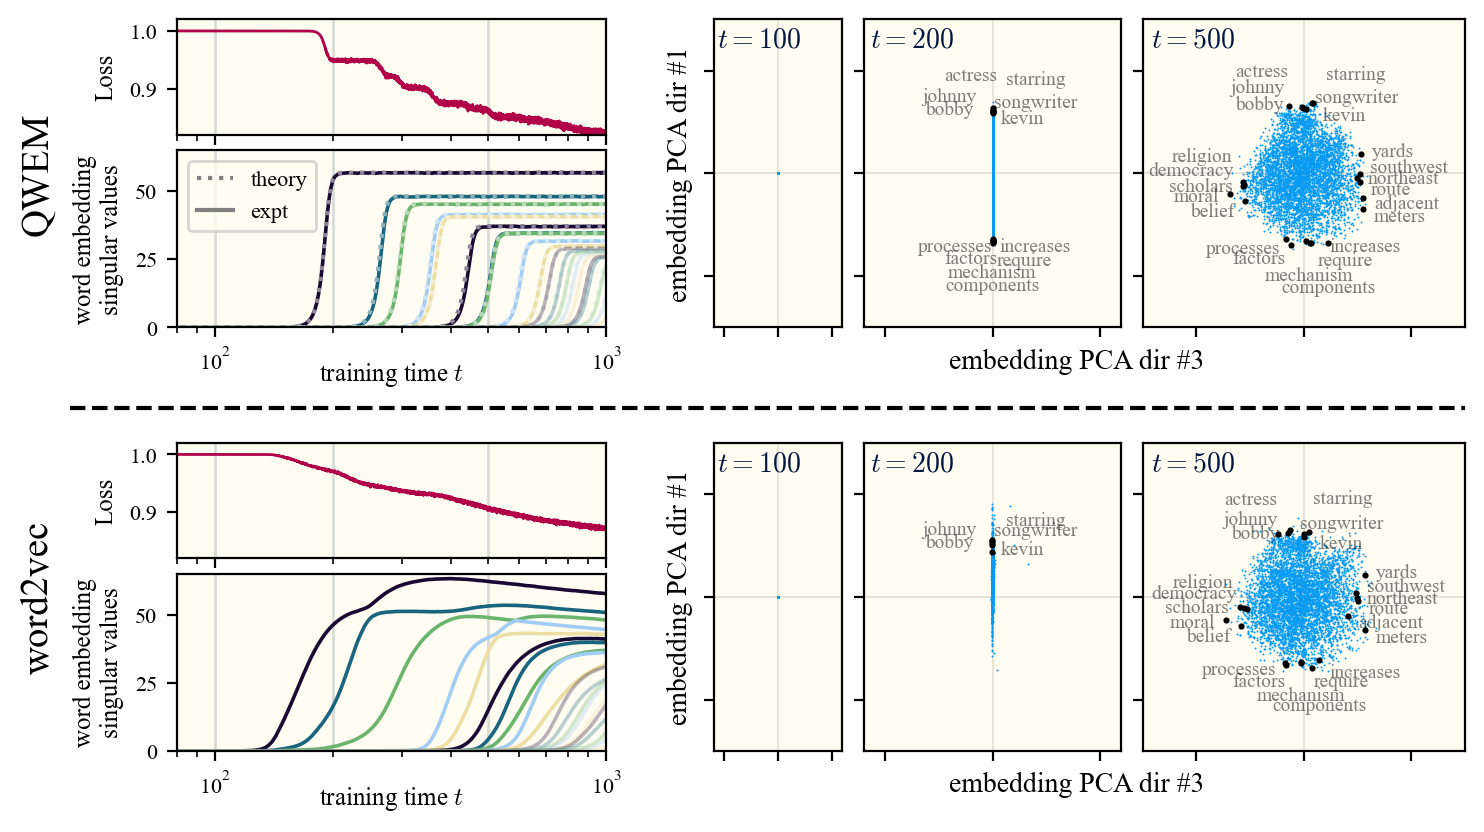

In [ ]:
import matplotlib.lines as mlines

def get_sv_color(j, scheme=0):
    colors = [
        "#002676 #76641C #D68C1D #F0B811 #FFCD50".split(" "),
        "#190933 #19647E #6BB46D #A1CDF4 #EDDEA4".split(' ')
    ]
    colors = colors[scheme]
    color = colors[j%5]
    if j < 10:
        alpha = 1
    elif j%20 == 0:
        alpha = 1
    else:
        alpha=0.3
    return color, alpha

fig = plt.figure(figsize=(9, 5))

rs = [slice(5,25), slice(30, 36), slice(37, 49), slice(50, 65)]
gs = fig.add_gridspec(100, 65, wspace=0, hspace=0)
axes = []
for i in range(2):
    s = 55*i
    row = {
        "loss": fig.add_subplot(gs[s:s+15,    rs[0]]),
        "sv": fig.add_subplot(gs[s+17:s+40, rs[0]]),
        "t0": fig.add_subplot(gs[s:s+40,    rs[1]]),
        "t1": fig.add_subplot(gs[s:s+40,    rs[2]]),
        "t2": fig.add_subplot(gs[s:s+40,    rs[3]])
    }
    axes.append(row)
    
    # Add a label on the left side of each row
    row_label = "QWEM" if  i==0 else "word2vec"
    ax_label = fig.add_subplot(gs[s:s+40, 0])
    ax_label.axis('off')
    ax_label.text(-1.5, 0.5, row_label, fontsize=14, ha='center', va='center', rotation=90)

    # dashed line separating the rows
    if i == 0:
        ax = fig.add_subplot(gs[50, 0:65])
        ax.plot([0, 1], [0, 0], color='black', linestyle='--')
        ax.axis('off')
        ax.set_xlim(0,1)
        ax.tick_params(axis='both', labelleft=False)

xmax = 3
for j, row in enumerate(axes):
    if j == 0:
        expt_dir = os.path.join(os.getenv("QWEMPATH"), "stepwise-qwem")
        fm = FileManager(expt_dir)
        results = fm.load("results.pickle")
        et_loss, et_acc, et_sv = [ExptTrace.deserialize(x) for x in results]
        fm.set_filepath("models")
        W_t = [
            fm.load("W_00001000.npy"),
            fm.load("W_00100000.npy"),
            fm.load("W_00500000.npy"),
        ]
        for i, W in enumerate(W_t):
            V, S, Ut = np.linalg.svd(W, full_matrices=False)
            W_t[i] = V @ np.diag(S)
    if j == 1:
        expt_dir = os.path.join(os.getenv("QWEMPATH"), "stepwise-sgns")
        fm = FileManager(expt_dir)
        results = fm.load("results.pickle")
        et_loss, et_acc, et_sv = [ExptTrace.deserialize(x) for x in results]
        fm.set_filepath("models")
        W_t = [
            fm.load("W_00001000.npy"),
            fm.load("W_00070000.npy"),
            fm.load("W_00330000.npy"),
        ]
        for i, W in enumerate(W_t):
            V, S, Ut = np.linalg.svd(W, full_matrices=False)
            sign = -1 if i==2 else 1
            W_t[i] = sign*V @ np.diag(S)
    tscale2 = .002
    tt = np.array(et_sv.get_axis("nstep"))
    SVs = np.array(et_sv[:])
    for i, (axname, ax) in enumerate(row.items()):
        if axname == "loss":
            nsteps = np.array(et_loss.get_axis("nstep"))
            tshift = 1 if j==0 else 1.4
            ax.plot(tshift*tscale2*nsteps, et_loss[:], color="xkcd:raspberry", lw=1)
            ax.set_ylim(.82, 1.02)
            ax.set_ylabel("Loss", fontsize=9)
            ax.tick_params(axis='y', labelsize=8)
            ax.tick_params(axis='x', labelbottom=False)
        if axname == "sv":           
            for i, eigval in enumerate(eigvals[:20]):
                color, alpha = get_sv_color(i, scheme=1)
                if j==0:
                    ax.plot(tscale2*tt, SVs[:, i], color=color, alpha=alpha, lw=1.3, zorder=-3)
                    ax.plot(tscale2*tchar*tt_th, SV_th[:, i], color=lighten(color, factor=.5), ls=":", alpha=alpha)            
                    line_theory = mlines.Line2D([], [], color='gray', linestyle=':', label='theory')
                    line_expt = mlines.Line2D([], [], color='gray', linestyle='-', label='expt')
                    ax.legend(handles=[line_theory, line_expt], fontsize=8, markerscale=0.8, labelspacing=0.5, handlelength=1.6)
                else:
                    ax.plot(tshift*tscale2*tt, SVs[:, i], color=color, alpha=alpha, ls="-", lw=1.3)
            ax.set_ylim(0, 65)
            ax.set_ylabel(f"word embedding\nsingular values", fontsize=9)
            ax.set_xlabel(f"training time $t$", fontsize=9, labelpad=-5)
            ax.tick_params(axis='y', labelsize=8)
            ax.tick_params(axis='x', labelsize=8)
        if axname in ["loss", "sv"]:
            ax.set_xscale("log")
            ax.set_xlim(tscale2*4e4, tscale2*5e5)
            ax.axvline(x=tscale2*50_000, lw=1, color='xkcd:light gray', zorder=-4)
            ax.axvline(x=tscale2*100_000, lw=1, color='xkcd:light gray', zorder=-4)
            ax.axvline(x=tscale2*250_000, lw=1, color='xkcd:light gray', zorder=-4)
            
        if axname in ["t0", "t1", "t2"]:
            W = W_t[i-2]
            scatter = ax.scatter(W[::2, 2], W[::2, 0], s=2, alpha=1, marker='.', lw=0, color="xkcd:azure")
            scatter.set_rasterized(True)
            labvecs = []

            xoff = [-1, -1., -.5, 1, 1., .7]\
                +[-.9, 1, .75, 0, -.5, 0]\
                +[-.2, -.2, -.2, -.2, -.2]\
                +[.2, .2, .2, .2, .2, .2]
            yoff = [-.2, .12, .5, .45, .02, -.3]\
                +[.1, .1, -.2, -.45, -.2, -.7]\
                +[-.05, 0, .5, .3, -.2]\
                +[-.15, .05, .13, -.15, -.02, -.12]
            for k, (word, tok) in enumerate(labelled_words_toks.items()):
                wvec = [W[tok, 2], W[tok, 0]]
                if np.linalg.norm(wvec) > .8:
                    labvecs.append(wvec)
                    ax.text(wvec[0] + xoff[k], wvec[1] + yoff[k], word, fontsize=7,
                            verticalalignment=vertaligns[k],
                            horizontalalignment=horizaligns[k],
                            alpha=0.5)
            if len(labvecs) > 0:
                labvecs = np.array(labvecs)
                scatter = ax.scatter(labvecs.T[0], labvecs.T[1], color='black', s=20, marker='.', lw=0)
                scatter.set_rasterized(True)
            ax.tick_params(axis='x', labelbottom=False)
            ax.tick_params(axis='y', labelleft=False)
            ax.set_xlim(-xmax, xmax)
            ax.set_ylim(-xmax, xmax)
            ax.axhline(0, lw=.7, color='k', alpha=0.1, zorder=-4)
            ax.axvline(0, lw=.7, color='k', alpha=0.1, zorder=-4)
        if axname == "t0":
            ax.set_ylabel("embedding PCA dir #1", fontsize=10)
            ax.text(-.95*xmax, .95*xmax, f"$t=100$", color="xkcd:navy", verticalalignment="top", fontsize=10)
        if axname == "t1":
            ax.set_xlabel(" "*24 + "embedding PCA dir #3", fontsize=10)
            ax.text(-.95*xmax, .95*xmax, f"$t=200$", color="xkcd:navy", verticalalignment="top", fontsize=10)
        if axname == "t2":
            ax.text(-.95*xmax, .95*xmax, f"$t=500$", color="xkcd:navy", verticalalignment="top", fontsize=10)

plt.savefig('fig1.pdf', format='pdf', bbox_inches='tight')